# Binary classification with Support Vector Machines (SVM)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from ipywidgets import interact, interactive, fixed
from numpy.random import default_rng

plt.rcParams['figure.figsize'] = [9.5, 6]
rng = default_rng(seed=42)

## Two Gaussian distributions

Let's generate some data, two sets of Normally distributed points...

In [2]:
def plot_data():
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.plot(x1, y1, 'bs', markersize=6)
    plt.plot(x2, y2, 'rx', markersize=6)

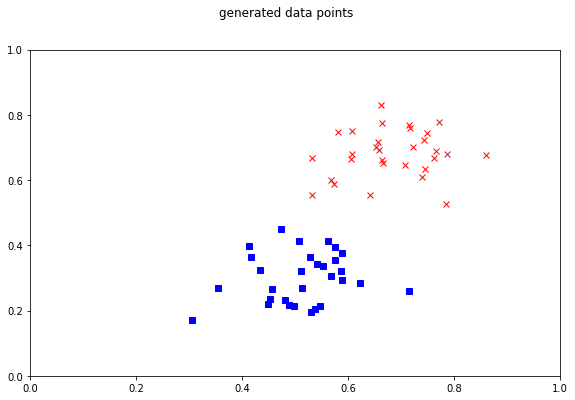

In [3]:
s1=0.01
s2=0.01
n1=30
n2=30

x1, y1 = rng.multivariate_normal([0.5, 0.3], [[s1, 0], [0, s1]], n1).T
x2, y2 = rng.multivariate_normal([0.7, 0.7], [[s2, 0], [0, s2]], n2).T
plot_data()
plt.suptitle('generated data points')
plt.show()

## Separating hyperplane

Linear classifiers: separate the two distributions with a line (hyperplane)

In [4]:
def plot_line(slope, intercept, show_params=False):
    x_vals = np.linspace(0.0, 1.0)
    y_vals = slope*x_vals +intercept
    plt.plot(x_vals, y_vals, '--')
    if show_params:
        plt.title('slope={:.4f}, intercept={:.4f}'.format(slope, intercept))

You can try out different parameters (slope, intercept) for the line. Note that there are many (in fact an infinite number) of lines that separate the two classes.

In [5]:
#plot_data()
#plot_line(-1.1, 1.1)
#plot_line(-0.23, 0.62)
#plot_line(-0.41, 0.71)
#plt.savefig('just_points2.png')

In [6]:
def do_plot_interactive(slope=-1.0, intercept=1.0):
    plot_data()
    plot_line(slope, intercept, True)
    plt.suptitle('separating hyperplane (line)')

interactive_plot = interactive(do_plot_interactive, slope=(-2.0, 2.0), intercept=(0.5, 1.5))
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

interactive(children=(FloatSlider(value=-1.0, description='slope', max=2.0, min=-2.0), FloatSlider(value=1.0, …

## Logistic regression

Let's create a training set $\mathbf{X}$ with labels in $\mathbf{y}$ with our points (in shuffled order).

In [7]:
X = np.block([[x1, x2], [y1, y2]]).T
y = np.hstack((np.repeat(0, len(x1)), np.repeat(1, len(x2))))

rand_idx = rng.permutation(len(x1) + len(x2))
X = X[rand_idx]
y = y[rand_idx]
print(X.shape, y.shape)
print(X[:10,:])
print(y[:10].reshape(-1,1))

(60, 2) (60,)
[[0.51278404 0.26837574]
 [0.53126656 0.55528875]
 [0.41755188 0.36505928]
 [0.76255904 0.66906535]
 [0.48151376 0.23190705]
 [0.49831988 0.21469561]
 [0.640585   0.55539421]
 [0.77112266 0.77933472]
 [0.50660307 0.41272412]
 [0.65727474 0.71585397]]
[[0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]]


The task is now to learn a classification model $\mathbf{y} = f(\mathbf{X})$.

First, let's try [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [8]:
clf_lr = LogisticRegression(penalty='none')
clf_lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

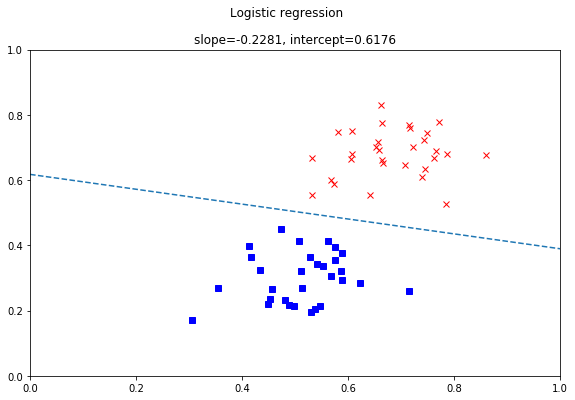

In [9]:
w1 = clf_lr.coef_[0][0]
w2 = clf_lr.coef_[0][1]
b = clf_lr.intercept_[0]

plt.suptitle('Logistic regression')
plot_data()
plot_line(slope=-w1/w2, intercept=-b/w2, show_params=True)

## Linear SVM

In [10]:
clf_lsvm = SVC(C=1000, kernel='linear')
clf_lsvm.fit(X, y)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

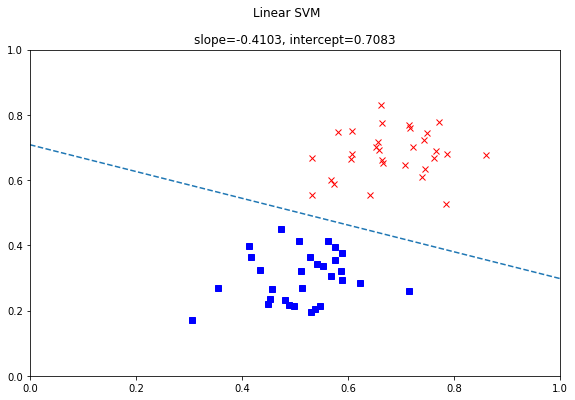

In [11]:
w1 = clf_lsvm.coef_[0][0]
w2 = clf_lsvm.coef_[0][1]
b = clf_lsvm.intercept_[0]

plt.suptitle('Linear SVM')
plot_data()
plot_line(slope=-w1/w2, intercept=-b/w2, show_params=True)

In [12]:
def plot_clf(clf):
    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

Let's try different $C$ values. We'll also visualize the margins and support vectors.

In [13]:
def do_plot_svm(C=1000.0):
    clf = SVC(C=C, kernel='linear')
    clf.fit(X, y)
    plot_data()
    plot_clf(clf)
    
interactive_plot = interactive(do_plot_svm, C=widgets.FloatLogSlider(value=1000, base=10, min=-0.5, max=4, step=0.2))
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(FloatLogSlider(value=1000.0, description='C', min=-0.5, step=0.2), Output(layout=Layout(…

In [ ]:
#do_plot_svm()
#plt.savefig('linear-svm.png')

## Kernel SVM

In [14]:
clf_ksvm = SVC(C=10, kernel='rbf')
clf_ksvm.fit(X, y)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

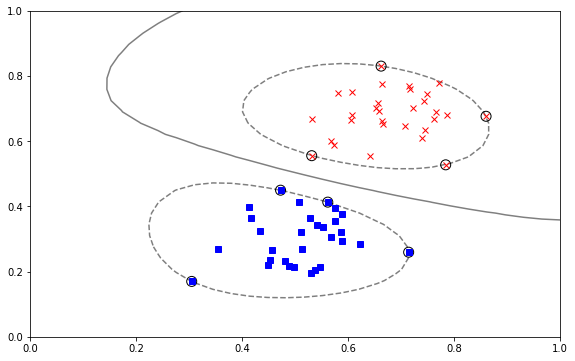

In [15]:
plot_data()
plot_clf(clf_ksvm)
plt.savefig('kernel-svm.png')

In [18]:
def do_plot_svm(C=1000.0):
    clf = SVC(C=C, kernel='rbf')
    clf.fit(X, y)
    plot_data()
    plot_clf(clf)
    
interactive_plot = interactive(do_plot_svm, C=widgets.FloatLogSlider(value=100, base=10, min=-1, max=3, step=0.2))
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(FloatLogSlider(value=100.0, description='C', max=3.0, min=-1.0, step=0.2), Output(layout…